In [1]:
import os
import sys
import time
os.environ['TF_ENABLE_ONEDNN_OPTS'] = str(0)

import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras  # tf.keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipyparams
import json

from test_utility import *

print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)
    
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

2023-06-28 17:45:05.600236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 17:45:05.784159: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-28 17:45:06.590995: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-28 17:45:06.591090: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object fi

<IPython.core.display.Javascript object>

python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
matplotlib 3.5.3
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.10.1
keras.api._v2.keras 2.10.0


In [3]:
notebookName = None
try:
    notebookName = os.path.basename(globals()['__vsc_ipynb_file__'])
except:
    pass

if type(notebookName) == str and len(notebookName.split('.')) > 1:  # looks like running on VSCode
    pass
else:  # looks like running on a browser
    notebookName = ipyparams.notebook_name
assert type(notebookName) == str and len(notebookName.split('.')) > 2
notebookName = ".".join(notebookName.split('.')[:-2])   # -2: gets rid of train version and file extention.
print(notebookName)

data_model = notebookName  #"vm03.05.250.11.80.100.16.14.1"
assert len(notebookName.split('.')) >= 8

v5.05.300.11.70.eth.60.12


In [4]:
dir_data = "/mnt/data/Trading/"

#===================================================================== Dataset

Nx = 300 # ------------- test
Ny = 11
Ns = 5 #--------------------- test
BatchSize = 16 * 14 # 12 #128 * 5 # 9, 32 * 4, 16 * 8

Shift = 0 # 2

CandleFile = "18-01-01-00-00-23-05-20-20-23-5m"
CandleFile2 = "23-05-19-00-05-23-06-22-02-40-5m"
CandleFile3 = "23-06-21-00-05-23-06-26-17-36-5m"
SmallSigma = 1
LargeSigma = 30
eFreeNoLog = True

shuffle_batch = 30  # Keep it small to speed up model loading.

dir_candles = os.path.join(dir_data, "Candles")

Volume_Volatility = 1
All_Field_Names = ['ClosePrice', 'BaseVolume', 'BuyerBaseVolume']
min_true_candle_percent_x = 70
chosen_markets_x = []
chosen_fields_names_x = ['ClosePrice', 'BaseVolume']
min_true_candle_percent_y = 70
assert min_true_candle_percent_x == min_true_candle_percent_y
chosen_markets_y = []
chosen_fields_names_y = ['ClosePrice', 'BaseVolume']
assert len(chosen_fields_names_x) == len(chosen_fields_names_y)
target_field_names = ['ClosePrice']

target_market_names = None
# target_market_names = ['NEOUSDT', 'LTCUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'QTUMUSDT', 'ADAUSDT', 'XRPUSDT']
target_market_names = ['ETHUSDT']
tarket_market_top_percent = 15

Standardization = True
Kill_Irregulars = True  # ----------------- pls implement it
Time_into_X = True
Time_into_Y = False #
eFreeNoPlot = True

#======================================================================== Model

Num_Layers = 60 # Wow
Num_Heads = 1   # As we have a single GPU, and we want to a exhaustic attention.
Factor_FF = 4
repComplexity = 12  # Wower
Dropout_Rate = 0.  # You cannot change this once the model is built.

dir_Checkpoint = os.path.join(dir_data, "Checkpoints")
checkpoint_filepath = os.path.join(dir_Checkpoint, data_model)
dir_CSVLogs = os.path.join(dir_data, "CSVLogs")
csvLogger_filepath = os.path.join(dir_CSVLogs, data_model)

#======================================================================== Train

Epochs_Initial = 5000
HuberThreshold = 4.0
Checkpoint_Monitor = "val_loss"
EarlyStopping_Min_Monitor = "val_loss"
EarlyStopping_Patience = 5000

Optimizer = "adam"
LR_initial = 1.e-6 # default: 1e-4
LR_rate = 0./100
LR_skip = 0

#=============================================================== Checksum

params = data_model.split('.')
assert int(params[1]) == int(CandleFile.split('-')[-1][:-1])
assert int(params[2]) == Nx
assert int(params[3]) == Ny
assert int(params[4]) == min_true_candle_percent_x
assert int(params[6]) == Num_Layers
assert int(params[7]) == repComplexity
targets = params[5]
if targets.isnumeric():
    assert target_market_names is None
    assert int(targets) == tarket_market_top_percent
else:
    for target in targets.split(','):
        assert (target+'usdt').upper() in target_market_names

#============================================================== Consistency
folders = [dir_data, dir_candles, dir_Checkpoint, dir_CSVLogs]
for folder in folders:
    if not os.path.isdir(folder):
        os.mkdir(folder)

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print(gpus)
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # tf.config.experimental.set_virtual_device_configuration(
            #     gpu,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)]) # why 5120?
            # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

mirrored_strategy = None
if len(gpus) > 1: 
    mirrored_strategy = tf.distribute.MirroredStrategy()
    LR_initial = LR_initial * len(gpus) * 3 / 4

# tf.config.experimental.set_virtual_device_configuration(
#     gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
#==================== Load candle and reports. Data structure depends on TradingBot ====================
Candles = np.load( os.path.join( dir_candles, "table-" + CandleFile + ".npy") )
with open( os.path.join( dir_candles, "reports-" + CandleFile + ".json"), "r") as f:
    reports = json.loads(f.read())

#==================== Load candle and reports. Data structure depends on TradingBot ====================
Candles2 = np.load( os.path.join( dir_candles, "table-" + CandleFile2 + ".npy") )
with open( os.path.join( dir_candles, "reports-" + CandleFile2 + ".json"), "r") as f:
    reports2 = json.loads(f.read())

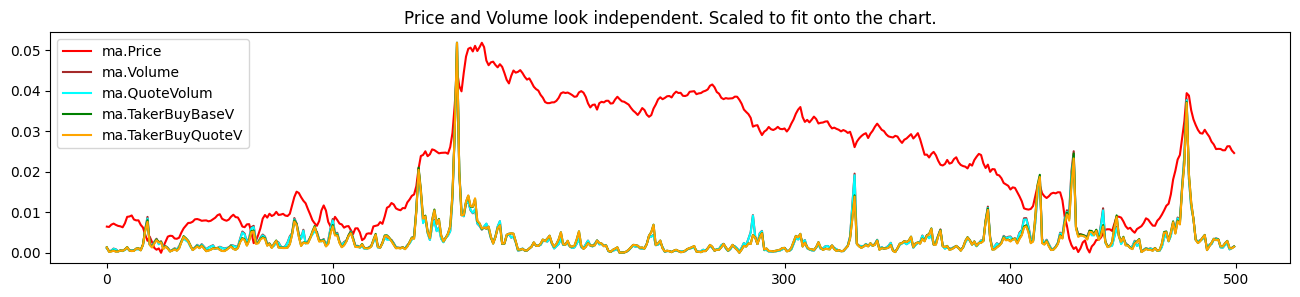

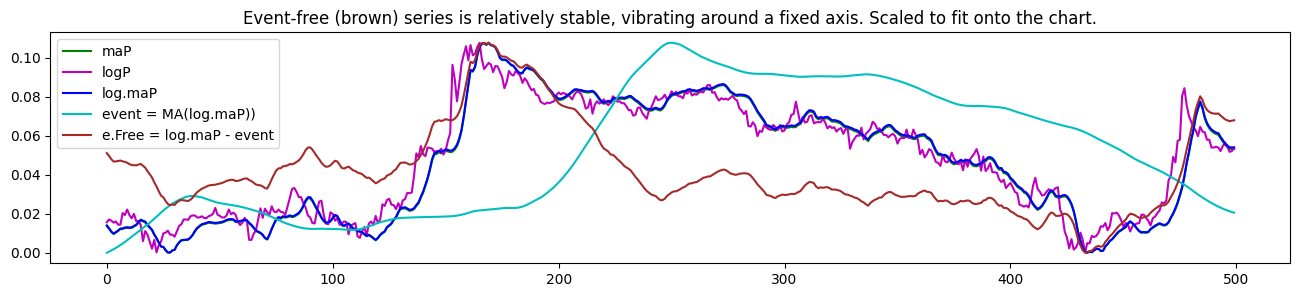

In [7]:
market = 5
Show_Price_Volume_10(Candles[market, :, :], 1, 1, 500)
Event_Free_Learning_Scheme_10(Candles[market, :, :], 3, 30, 500)

In [8]:
#==================== Format candles data ====================================
Candles, CandleMarks, all_market_names, x_indices, y_indices, \
chosen_market_names_x, chosen_field_names_x, chosen_market_names_y, chosen_field_names_y, \
chosen_market_names, chosen_field_names, \
target_markets_names, target_markets, target_field_mask = \
get_formed_data_4(
        Candles, reports, All_Field_Names, 
        min_true_candle_percent_x, chosen_fields_names_x, min_true_candle_percent_y, chosen_fields_names_y,
        target_field_names, target_market_names, tarket_market_top_percent
)

In [9]:
print(Candles.shape)
print(CandleMarks.shape)
print(len(all_market_names))
print(x_indices)
print(y_indices)
print(chosen_market_names_x)
print(chosen_field_names_x)
print(chosen_market_names_y)
print(chosen_field_names_y)
print(chosen_market_names)
print(chosen_field_names)
print(target_markets_names)
print(target_markets)
print(len(chosen_market_names_x), len(chosen_market_names_y), len(target_markets_names))

(565633, 45, 2)
(565633, 45)
336
((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44), (0, 1))
((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44), (0, 1))
['NEOUSDT', 'LTCUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'QTUMUSDT', 'ADAUSDT', 'XRPUSDT', 'EOSUSDT', 'XLMUSDT', 'IOTAUSDT', 'ONTUSDT', 'TRXUSDT', 'ETCUSDT', 'ICXUSDT', 'NULSUSDT', 'VETUSDT', 'LINKUSDT', 'WAVESUSDT', 'ONGUSDT', 'HOTUSDT', 'ZILUSDT', 'ZRXUSDT', 'FETUSDT', 'BATUSDT', 'XMRUSDT', 'ZECUSDT', 'IOSTUSDT', 'CELRUSDT', 'DASHUSDT', 'OMGUSDT', 'THETAUSDT', 'ENJUSDT', 'MATICUSDT', 'ATOMUSDT', 'TFUELUSDT', 'ONEUSDT', 'FTMUSDT', 'ALGOUSDT', 'DOGEUSDT', 'DUSKUSDT', 'ANKRUSDT', 'WINUSDT', 'COSUSDT', 'COCOSUSDT']
['ClosePrice', 'BaseVolume']
['NEOUSDT', 'LTCUSDT', 'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'Q

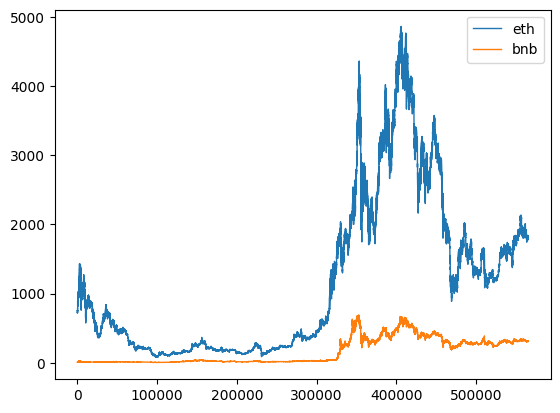

In [10]:
market = all_market_names.index("ETHUSDT")
plt.plot(Candles[:, market, 0], label='eth', linewidth=1)
market = all_market_names.index("BNBUSDT")
plt.plot(Candles[:, market, 0], label='bnb', linewidth=1)
plt.legend()
plt.show()

In [11]:
Candles2, CandleMarks2, missing_names2 = get_conformed_data_3(
    Candles2, reports2, chosen_market_names,
    All_Field_Names, chosen_field_names
 )

missing_markets ['COCOSUSDT']


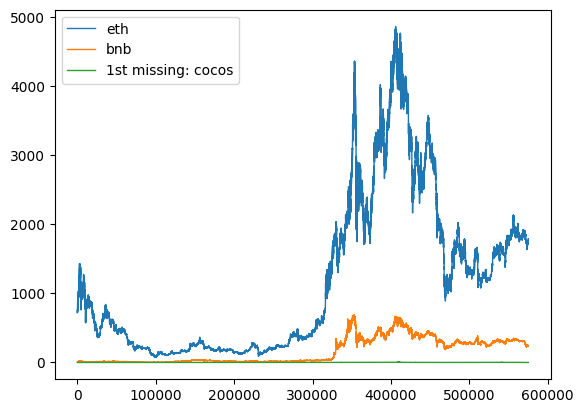

In [12]:
market = all_market_names.index("ETHUSDT")
joined = np.concatenate([Candles[:, market, 0], Candles2[:, market, 0]], axis=0)
plt.plot(joined, label='eth', linewidth=1)
market = all_market_names.index("BNBUSDT")
joined = np.concatenate([Candles[:, market, 0], Candles2[:, market, 0]], axis=0)
plt.plot(joined, label='bnb', linewidth=1)
if len(missing_names2) > 0:
    market = all_market_names.index(missing_names2[0])
    joined = np.concatenate([Candles[:, market, 0], Candles2[:, market, 0]], axis=0)
    plt.plot(joined, label="1st missing: " + missing_names2[0][:-len('USDT')].lower(), linewidth=1)
plt.legend()
plt.show()

In [13]:
#=========================== Get time features ======================
start_ts, interval_s, timestamps_abs, Times = get_joint_time_features_2(CandleFile, Candles.shape[0], Candles.dtype)

# start_ts2, _, timestamps_abs2, Times2 = get_joint_time_features_2(CandleFile2, Candles2.shape[0], Candles2.dtype)
# assert timestamps_abs2[0] - timestamps_abs[-1] == interval_s

In [14]:
# print(Candles.shape, Times.shape)
# print(timestamps_abs[:5])
# print(Candles2.shape, Times2.shape)
# print(timestamps_abs2[:5])
# # print(Times[:5])    # Agnostic of restart of this training notebook.

In [15]:
#========================= Get sample anchors ==============================
sample_anchors_t, sample_anchors_v = get_sample_anchors_3(Candles, Nx, Ny, Ns, seed=523)
print(sample_anchors_t.shape, sample_anchors_v.shape)
print(sample_anchors_t[:5])
assert sample_anchors_t[0] == 366760 
assert sample_anchors_t[1] == 118030

sample_anchors_t2, sample_anchors_v2 = get_sample_anchors_3(Candles2, Nx, Ny, Ns, seed=523)
print(sample_anchors_t2.shape, sample_anchors_v2.shape)
print(sample_anchors_t2[:5])
assert sample_anchors_t2[0] == 5365 
assert sample_anchors_t2[1] == 8585

(79144,) (33920,)
[366760 118030 416155  82070 167580]
(1286,) (552,)
[5365 8585 8675 5830 3415]


In [16]:
JointCandles, JointMarks, sample_anchors_t, sample_anchors_v = \
    get_joint_data(
        Candles, CandleMarks, sample_anchors_t, sample_anchors_v,
        Candles2, CandleMarks2, sample_anchors_t2, sample_anchors_v2
    )

(575137, 45, 2)
565315
[570680 573900 573990 571145 568730]
(80430,) (34472,)


In [17]:
print(JointCandles.shape)
print(sample_anchors_t.shape, sample_anchors_v.shape)

(575137, 45, 2)
(80430,) (34472,)


In [18]:
start_ts, interval_s, timestamps_abs, JointTimes = get_joint_time_features_2(CandleFile, JointCandles.shape[0], JointCandles.dtype)
size_time = Times.shape[1]

In [19]:
#======================== Get event-free data ========================

org_length = JointCandles.shape[0]
JointCandles, JointMarks, JointTimes = get_eventfree_data(
    JointCandles, JointMarks, JointTimes,
    SmallSigma, LargeSigma, all_market_names, chosen_market_names, 
    All_Field_Names, chosen_field_names,
    eFreeNoLog, eFreeNoPlot, Volume_Volatility
)

In [20]:
assert JointCandles.shape[0] == JointMarks.shape[0]
assert JointCandles.shape[0] == JointTimes.shape[0]
print(JointCandles.shape, CandleMarks.shape, JointTimes.shape, org_length-JointCandles.shape[0])
# print(Candles[-3:]) # Agnostic of restart of this training notebook.

(575040, 45, 2) (565633, 45) (575040, 4) 97


In [21]:
#========================= Standardize data ============================
Standard = None
if Standardization:
    JointCandles, Standard = standardize_2(JointCandles)
# print(Candles[-3:]) # Agnostic of restart of this training notebook.

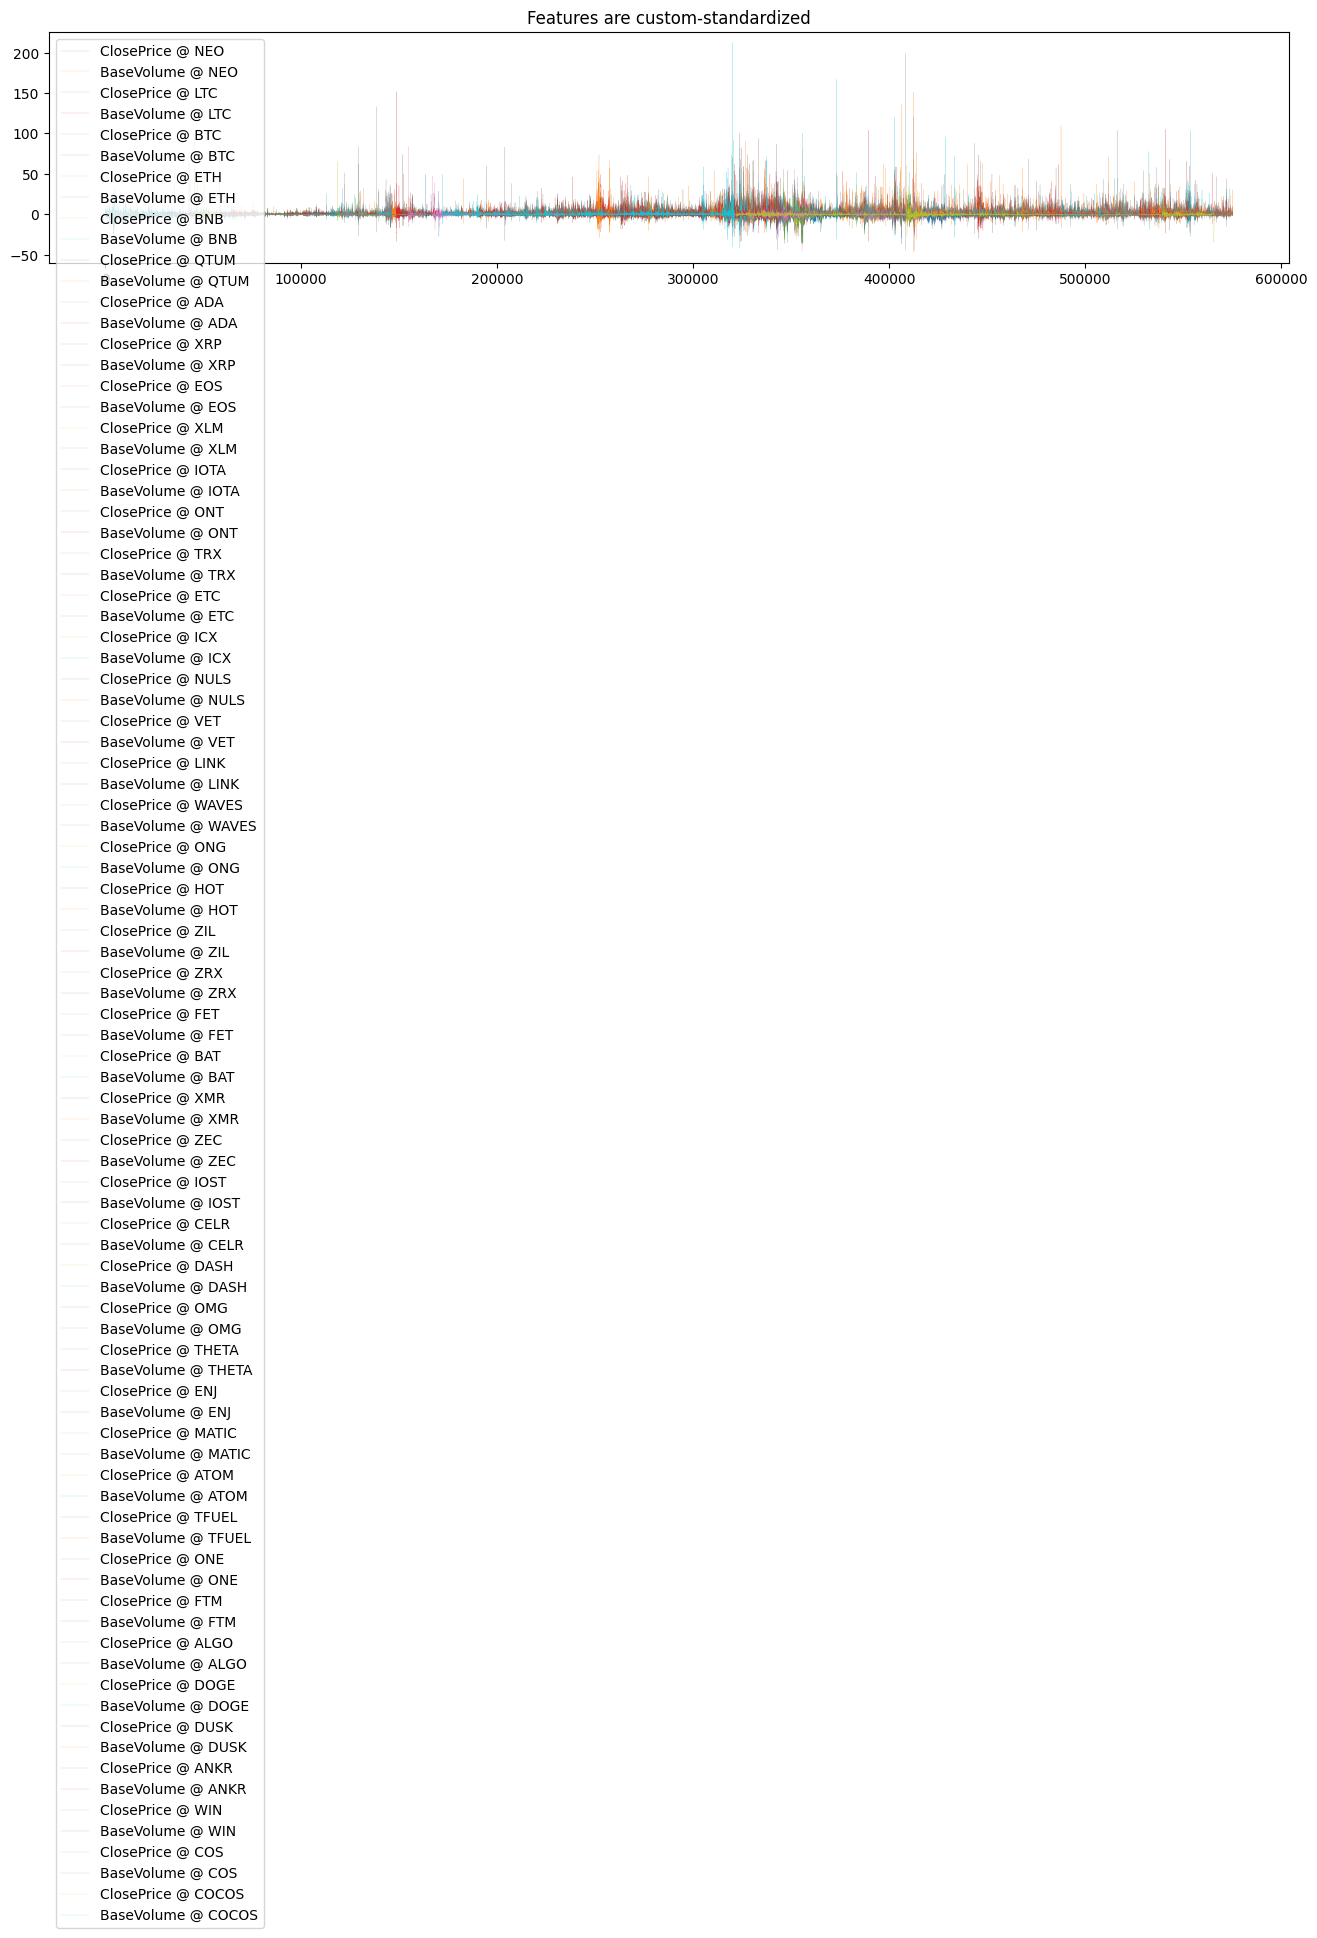

In [22]:
fig = plt.figure(figsize=(16,3))
ax = fig.add_subplot(111)
ax.set_title("Features are custom-standardized" if Standardization else "Features are not standardized")
for market in range(JointCandles.shape[1]):
    for field in range(JointCandles.shape[2]):
        ax.plot(JointCandles[:, market, field], label = "{} @ {}".format(All_Field_Names[field], all_market_names[market][:-len('USDT')]), lw=0.1)
ax.legend(loc = 'upper left')
plt.show()

In [23]:
ds_train, ds_valid, dx, dy, non_target_markets_relative, target_field_mask = \
get_datasets_no_end_single_point(
    JointCandles, Time_into_X, Time_into_Y, JointTimes, 
    sample_anchors_t, sample_anchors_v,
    Nx, x_indices, Ny, y_indices, size_time, target_markets, target_field_mask, Shift,
    BatchSize, shuffle_batch, shuffle=(len(gpus)<=1)
)
# get_datasets_3(
#     JointCandles, Time_into_X, Time_into_Y, JointTimes, 
#     sample_anchors_t, sample_anchors_v,
#     Nx, x_indices, Ny, y_indices, size_time, target_markets, Shift,
#     BatchSize, shuffle_batch, shuffle=(len(gpus)<=1)
# )

2023-06-28 17:46:13.146759: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 17:46:15.367001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38237 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


In [24]:
model = None

if mirrored_strategy is None:
    model = build_model_3(
        dx, dy, Num_Layers, Num_Heads, Factor_FF, repComplexity, Dropout_Rate,
        HuberThreshold, Optimizer, initial=LR_initial, rate=LR_rate, skip=LR_skip
    )
else:
    with mirrored_strategy.scope():
        model = build_model_3(
            dx, dy, Num_Layers, Num_Heads, Factor_FF, repComplexity, Dropout_Rate,
            HuberThreshold, Optimizer, initial=LR_initial, rate=LR_rate, skip=LR_skip
        )

Loading a checkpoint...done


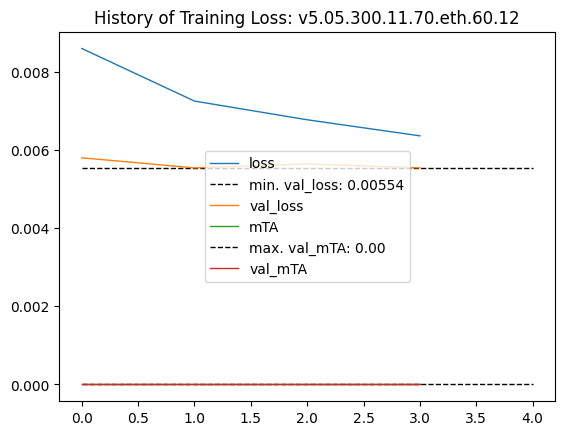

In [25]:
callbacks = get_callbacks(
    checkpoint_filepath, Checkpoint_Monitor, 
    csvLogger_filepath, 
    EarlyStopping_Min_Monitor, EarlyStopping_Patience
)
try:
    model.load_weights(checkpoint_filepath)
    print("Loading a checkpoint...done")
except:
    print("No chekkpoint to load. Fitting initailly...")
    model.fit(
        ds_train, # x and y_true
        validation_data=ds_valid,
        epochs=1, #Epochs_Initial,
        callbacks=callbacks
    )
try:
    columns = ('loss', 'val_loss', 'mTA', 'val_mTA')
    plot_csv_train_history(csvLogger_filepath, columns, title=data_model)
except:
    pass

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 candle_input_x (InputLayer)    [(None, None, 94)]   0           []                               
                                                                                                  
 candle_input_y (InputLayer)    [(None, None, 94)]   0           []                               
                                                                                                  
 trans (ConTransformer)         (None, None, 94)     16746194    ['candle_input_x[0][0]',         
                                                                  'candle_input_y[0][0]']         
                                                                                                  
Total params: 16,746,194
Trainable params: 16,746,194
Non-trainable params: 0
________________

In [ ]:
model.fit(
    ds_train, # x and y_true
    validation_data=ds_valid,
    epochs=Epochs_Initial,
    callbacks=callbacks
)

Epoch 1/5000


2023-06-28 17:49:43.056953: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-28 17:49:43.057188: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-28 17:49:44.784338: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


153/360 [===========>..................] - ETA: 3:41 - loss: 0.6495 - mTA: 0.0000e+00

In [ ]:
columns = ('loss', 'val_loss', 'mTA', 'val_mTA')
plot_csv_train_history(csvLogger_filepath, columns, title=data_model)

# Inference

In [ ]:
#==================== Load candle and reports. Data structure depends on TradingBot ====================
Candles3 = np.load( os.path.join( dir_candles, "table-" + CandleFile3 + ".npy") )
with open( os.path.join( dir_candles, "reports-" + CandleFile3 + ".json"), "r") as f:
    reports3 = json.loads(f.read())

In [ ]:
Candles3, CandleMarks3, missing_names3 = get_conformed_data_3(
    Candles3, reports3, chosen_market_names,
    All_Field_Names, chosen_field_names
 )

In [ ]:
print(Candles3.shape)

In [ ]:
start_ts3, interval_s, timestamps_abs3, Times3 = \
    get_standalone_time_features(CandleFile, CandleFile3, Candles3.shape[0], Candles3.dtype)

In [ ]:
#======================== Get event-free data ========================

org_length = Candles3.shape[0]
Candles3, CandleMarks3, Times3 = get_eventfree_data(
    Candles3, CandleMarks3, Times3,
    SmallSigma, LargeSigma, all_market_names, chosen_market_names, 
    All_Field_Names, chosen_field_names,
    eFreeNoLog, eFreeNoPlot, Volume_Volatility
)

In [ ]:
if Standardization:
    Candles3 = standardize_observation(Candles3, Standard)

In [ ]:
# del Candles, Candles2

step = Ny
pred_base_ts = timestamps_abs3[ np.array(range(timestamps_abs3.shape[0]-1, 0, -step) , dtype=np.int64) ]
Candles3_padded = np.pad(Candles3, [[0, Ny], [0,0], [0,0]], constant_values=0)
print(Candles3.shape, Candles3_padded.shape)
Times3_padded = np.pad(Times3, [[0, Ny], [0,0]], constant_values=0) # pad with 0 assuming Time_into_Y == False
_sample_anchors_t = np.flip(np.array(range(Candles3_padded.shape[0] - Nx - Ny, 0, -step), dtype=np.int64), axis=0)
_sample_anchors_v = np.array([], dtype=np.int64)
_shift = 0; _batchSize = BatchSize ; _shuffle_batch = 0; _shuffle = False
_ds_train, _, _, _ = \
get_datasets_3(
    Candles3_padded, Time_into_X, Time_into_Y, Times3_padded,
    _sample_anchors_t, _sample_anchors_v,
    Nx, x_indices, Ny, y_indices, size_time, target_markets, _shift,
    _batchSize, _shuffle_batch, shuffle=_shuffle, cache=False
)

In [ ]:
# for anchor_id in range(_sample_anchors_t.shape[0]):
#     print(anchor_id)
#     size_y = get_timepoint_size(y_indices)
#     anchor = _sample_anchors_t[anchor_id]
#     y_anchor = Candles3_padded[anchor, y_indices[0], y_indices[1] ]
#     time_anchor = Times3_padded[anchor]

#     b_cnt = anchor_id // _batchSize
#     for ((x, y), _) in _ds_train:
#         if b_cnt == 0:
#             x = x.numpy(); y = y.numpy()
#             assert (x[anchor_id % _batchSize, 1, : size_y] == y_anchor).all()  # (batch, Nx, dx)
#             assert (x[anchor_id % _batchSize, 1, size_y : -1] == time_anchor).all()  # (batch, Nx, dx) time_features
#             break
#         else:
#             b_cnt -= 1

In [ ]:
anchor_start = _sample_anchors_t[0]

Candles3_pred = Candles3_padded.copy() # np.zeros_like(Candles3_padded, dtype=Candles3_padded.dtype)
Candles3_pred = np.zeros_like(Candles3_padded, dtype=Candles3_padded.dtype)

anchor_id = 0
size_y = get_timepoint_size(y_indices)
for ((x, y), _) in _ds_train: # must loop Ny + 1
    print(anchor_id, end=' ')
    x = x.numpy(); y = y.numpy(); y[:] = 0.0  # (batch, Ny+1, dy)  y[:, 0, :] == Start
    # print(x.shape, y.shape)
    for i in range(y.shape[1]):
        pred = model((x, y))    # pred: (batch, Ny+1, dy)
        pred = pred.numpy()

        pred[:, i, non_target_markets_relative] = 0.0
        pred[:, i, non_target_markets_relative] *= target_field_mask

        y[:, i] = pred[:, i]

    for b in range(x.shape[0]):
        anchor = _sample_anchors_t[anchor_id]
        print(anchor, end=' ')
        Candles3_pred[anchor + Nx: anchor + Nx + Ny] = y[b, :-1, :size_y].reshape((Ny, len(y_indices[0]), len(y_indices[1])))
        # print(b, anchor_id, anchor)
        anchor_id += 1

In [ ]:
market_name = "ETHUSDT"
market_id = all_market_names.index(market_name)
field_id = 0
print(market_id)

points = tuple(range(Candles3_padded.shape[0]))
lw = 0.5
plt.plot(Candles3_padded[:, market_id, field_id ], label='true', lw=lw)
plt.plot(Candles3_pred[:, market_id, field_id ], label='pred', lw=lw)
plt.legend()
plt.title(market_name)
plt.show()

In [ ]:
print(timestamps_abs3[-1])
print(datetime.fromtimestamp(timestamps_abs3[-1]))